# Run a Binary/Multiclass Classification Experiment with Cross-Validation

We are interested in extracting which features are necessarily important in the problem of separating out epilepsy from non-epilepsy scalp EEGs. We approach this problem from the lens of a statistical data science problem. 

We are given some relatively high-dimensional data over space and time for EEG, and are tasked with determining what properties of the data help a statistical algorithm consistently and robustly predict epilepsy and non-epilepsy.

We can guide the problem's statistics in several ways:

    - engineering of the features, X matrix
    - engineering of the y labels, y vector
    
Engineering the X matrix features can involve encoding certain priors of the data. For example, one might assume spatial information is important.

Engineering the y labels can involve different experimental design. Whether that is assuming that epilepsy normal EEGs are similar with epilepsy abnormal EEGs in feature space.

## To Add New Features

I implemented the `load_derived_datasets` and `get_X_features` functions inside episcalp, which handle loading datasets that are stored in BIDS derivative layout and then transforming those datasets into a feature matrix, X, for input into a classification task.

`Load_derived_datasets` just requires one to define a new reading function similar to how I've done for fragility and tfrs. Spikes are loaded in directly from the raw dataset using `_compute_spike_rates`. 

To try different features, one just needs to modify `get_X_features`.

In [249]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle
import warnings
import sys

from numpy.testing import assert_array_equal

warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    recall_score, jaccard_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,precision_score,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    cohen_kappa_score, make_scorer
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_validate,
    StratifiedShuffleSplit,
)
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
import sklearn
from sklearn import preprocessing

import mne
from mne.time_frequency import read_tfrs

mne.set_log_level("ERROR")
from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals, read_raw_bids

from eztrack.io import read_derivative_npy

sys.path.append("../../")
from episcalp.scripts.spikes.summary import _get_spike_annots
from episcalp.cross_validate import get_X_features, load_derived_datasets, _compute_spike_rates
from episcalp.preprocess.montage import _standard_lobes
from episcalp.utils.utils import NumpyEncoder

# if you installed sporf via README
#from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# this should be at least 1.0
print(sklearn.__version__)

1.1.dev0


In [107]:
y_enc = LabelEncoder()

In [108]:
def _get_exp_condition(subject, root):
    part_fname = os.path.join(root, "participants.tsv")
    df = pd.read_csv(part_fname, sep="\t")

    if not subject.startswith("sub-"):
        subject = f"sub-{subject}"

    return df[df["participant_id"] == subject]

In [109]:
def convert_experimental_cond_to_y(experimental_condition_list):
    """Encoder for y labels."""
    # Group name keys, assigned y-label values
    experimental_condition_map = {
        "non-epilepsy-normal-eeg": 0,
        "epilepsy-normal-eeg": 1,
        "epilepsy-abnormal-eeg": 1,
    }
    return [experimental_condition_map[cond] for cond in experimental_condition_list]

# Define possible helper functions

In [110]:
def _preprocess_epochs_tfr(data):
    assert data.ndim == 4

    # take the average over frequencies
    data = np.mean(data, axis=2)

    # move the epoch ("window") axis to last
    data = np.moveaxis(data, 0, -2)

    # compress the time axis
    data = np.mean(data, axis=-1)

    # convert to dB
    data = 20 * np.log10(data)

    data = np.reshape(data, (data.shape[0], -1))
    return data

In [111]:
def _load_subject_derivs(deriv_path, read_func, subjects=None, ignore_fpaths=None, search_str="*.npy"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)
    
    this_path = deriv_path
    while this_path.parent.name != 'derivatives' and this_path.parent.name != '/':
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            ignore=False
            for f in ignore_fpaths:
                if f in str(fpath):
                    print(f"Skipping fpath: {fpath}")
                    ignore=True
            if not ignore:
                deriv = read_func(fpath, source_check=False)

                # extract data
                ch_names = deriv.ch_names
                deriv_data = deriv.get_data()

                dataset["subject"].append(subject)
                dataset["data"].append(deriv_data)
                dataset["ch_names"].append(ch_names)
                dataset['roots'].append(root)

    return dataset

In [112]:
def _load_subject_tfrs(deriv_path, read_func, subjects=None, ignore_fpaths=None, search_str="*.h5"):
    if subjects is None:
        subjects = get_entity_vals(deriv_path, "subject")

    print(f"Loading data for subjects: {subjects}")
    print(deriv_path)
    
    this_path = deriv_path
    while this_path.parent.name != 'derivatives' and this_path.parent.name != '/':
        this_path = this_path.parent
    root = this_path.parent.parent

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = deriv_path / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.glob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            ignore=False
            for f in ignore_fpaths:
                if f in str(fpath):
                    print(f"Skipping fpath: {fpath}")
                    ignore=True
            if not ignore:
                deriv = read_func(fpath)[0]

                # extract data
                ch_names = deriv.ch_names
                deriv_data = deriv.data

                # apply mean across axis 2
                deriv_data = _preprocess_epochs_tfr(deriv_data)
    #             deriv_data = np.mean(deriv_data, axis=2)
                ch_names, deriv_data = removeC3C4(ch_names, deriv_data)
                
                dataset["subject"].append(subject)
                dataset["data"].append(deriv_data)
                dataset["ch_names"].append(ch_names)
                dataset['roots'].append(root)

    return dataset

In [113]:
def removeC3C4(chnames, data):
    chnames = np.array(chnames)
    data = np.array(data)
    keep_idx = []
    for idx, ch in enumerate(chnames):
        if ch not in ['C3', 'C4']:
            keep_idx.append(idx)
    chnames = chnames[keep_idx]
    data = data[keep_idx, :]
    return chnames, data

In [9]:
def _load_subject_spikes(root, subjects=None, search_str = "*.edf"):
    if subjects is None:
        subjects = get_entity_vals(root, "subject")

    print(f"Loading data for subjects: {subjects}")

    dataset = collections.defaultdict(list)
    for subject in subjects:
        subj_path = root / f"sub-{subject}"

        # get all files of certain search_str
        fpaths = subj_path.rglob(search_str)

        # now load in all file paths
        for fpath in fpaths:
            entities = get_entities_from_fname(fpath.name)
            bids_path = BIDSPath(root=root, datatype="eeg",
                                extension='.edf', **entities)
            raw = read_raw_bids(bids_path)

            # extract data
            ch_spike_rates = _compute_spike_rates(raw)

            # normalize spike counts
            for ch_name, val in ch_spike_rates.items():
                ch_spike_rates[ch_name] = val / (raw.n_times / raw.info["sfreq"])

            # total spike rate = total # of spikes regardless of channel / times / n_chs
            total_spike_rate = (
                np.sum(list(ch_spike_rates.values()))
                / len(raw.ch_names)
                / (raw.n_times / raw.info["sfreq"])
            )

            # max spike per lobe
            ch_spikes = np.array(list(ch_spike_rates.values()))
            lobe_dict = _standard_lobes(separate_hemispheres=False)

            # value of the max spike rate
            features = np.hstack(
                (
                    ch_spikes.mean(),
                    ch_spikes.std(),
                    np.quantile(ch_spikes, q=0.1),
                    np.quantile(ch_spikes, q=0.5),
                    np.quantile(ch_spikes, q=0.9),
                    total_spike_rate,
                )
            )
            ch_names = raw.ch_names

            assert len(ch_names) == len(ch_spike_rates.keys())
            assert_array_equal(ch_names, list(ch_spike_rates.keys()))

            dataset["data"].append(features)
            dataset["subject"].append(subject)
            dataset["ch_names"].append(ch_names)
            dataset['roots'].append(root)
    return dataset

In [114]:
def load_spike_results(spike_fpath):
    test_bids_paths = []
    test_proba = []
    with open(spike_fpath.with_suffix(".json"), "r") as fp:
        scores = json.load(fp)
    which_set = "test"
    n_splits = int(spike_fpath.name.split("_")[0].replace("cv",""))
    
    for idx in range(n_splits):
        subs = scores['test_subjects'][idx]
        sess = scores['test_sessions'][idx]
        tasks = scores['test_tasks'][idx]
        runs = scores['test_runs'][idx]
        for sub, ses, task, run in zip(subs, sess, tasks, runs):
            bids_params = {
                "subject": sub,
                "session": ses,
                "task": task,
                "run": run
            }
            bids_path = BIDSPath(**bids_params)
            test_bids_paths.append(bids_path)
        proba = scores['test_y_pred_proba'][idx]
        test_proba.extend(proba)
    return test_bids_paths, test_proba

In [115]:
def get_abnormal_subjects(bids_paths, y_proba, thresh=0.7):
    abnorm_bidspaths = []
    for bp, y_proba in zip(bids_paths, y_proba):
        if y_proba > thresh:
            abnorm_bidspaths.append(bp.basename)
    return abnorm_bidspaths

In [116]:
spikes_fpath = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Scalp_EEG_combined/derivatives/cv10_logreg_mtry6_exp_abnormalspikes_meandiff.json")
test_bidspaths, test_y_proba = load_spike_results(spikes_fpath)
abnorm_bidspaths = get_abnormal_subjects(test_bidspaths, test_y_proba)
abnorm_bidspaths

['sub-jhh110_run-01',
 'sub-jeff205_ses-1_run-1',
 'sub-jeff201_ses-1_run-6',
 'sub-jhh227_run-01',
 'sub-jhh214_run-01',
 'sub-jeff205_ses-1_run-1',
 'sub-jeff208_ses-1_run-1',
 'sub-jeff202_ses-1_run-2',
 'sub-jeff205_ses-1_run-1',
 'sub-jhh214_run-01',
 'sub-jeff206_ses-1_run-1',
 'sub-jhh213_run-01',
 'sub-jhh216_run-01',
 'sub-jhh213_run-01',
 'sub-jhh216_run-01',
 'sub-jeff206_ses-1_run-1']

# Define data directories

In [117]:
user = "patrick"
if user == "patrick":
    jhroot = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
    jeffroot = Path("D:/OneDriveParent/Johns Hopkins/Jefferson_Scalp - Documents/root")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")
elif user == "adam":
    jhroot = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/bids/")
    jeffroot = Path("/Users/adam2392/Johns Hopkins/Jefferson_Scalp - Documents/root/")

    # not ready yet
    upmcroot = Path("/Users/adam2392/Johns Hopkins/UPMC_Scalp - Documents/")

In [118]:
reference = "monopolar"
radius = "1.25"

# define derivative chains
ss_deriv_chain = Path("sourcesink") / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference

delta_tfr_deriv_chain = Path("tfr") / 'delta'
theta_tfr_deriv_chain = Path("tfr") / 'theta'
alpha_tfr_deriv_chain = Path("tfr") / 'alpha'
beta_tfr_deriv_chain = Path("tfr") / 'beta'

In [119]:
if user == "adam":
    root = Path("/Users/adam2392/Johns Hopkins/Scalp EEG JHH - Documents/")
elif user == "patrick":
    root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

# Load Feature Spatiotemporal Heatmap Datasets

In [120]:
exp_name = 'fragilityquantiles_jhhjeff_spikes'

In [121]:
roots = [jhroot, jeffroot]
deriv_chains = [frag_deriv_chain, frag_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = '*desc-perturbmatrix*.npy'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
fragility_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar
D:\O

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh004\sub-jhh004_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh005\sub-jhh005_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh006\sub-jhh006_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh007\sub-jhh007_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh008\sub-jhh008_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh009\sub-jhh009_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh010\sub-jhh010_run-01_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh011\sub-jhh011_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh012\sub-jhh012_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh013\sub-jhh013_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh014\sub-jhh014_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh015\sub-jhh015_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh016\sub-jhh016_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh017\sub-jhh017_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh018\sub-jhh018_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh019\sub-jhh019_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh020\sub-jhh020_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh021\sub-jhh021_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh022\sub-jhh022_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh023\sub-jhh023_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh024\sub-jhh024_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh025\sub-jhh025_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh026\sub-jhh026_run-01_desc-perturbmatrix_eeg.json


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh027\sub-jhh027_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh027\sub-jhh027_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh030

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh102\sub-jhh102_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh103\sub-jhh103_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh104\sub-jhh104_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh105\sub-jhh105_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh106\sub-jhh106_run-01_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh107\sub-jhh107_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh108\sub-jhh108_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh109\sub-jhh109_run-01_desc-perturbmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh110\sub-jhh110_run-01_desc-perturbmatrix_eeg.npy
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh111\sub-jhh111_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh112\sub-jhh112_run-01_desc-perturbmatrix_eeg.

  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh113\sub-jhh113_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh114\sub-jhh114_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh115\sub-jhh115_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh116\sub-jhh116_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh117\sub-jhh117_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh118\sub-jhh118_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh119\sub-jhh119_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh120\sub-jhh120_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh121\sub-jhh121_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh122\sub-jhh122_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh124\sub-jhh124_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh127\sub-jhh127_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh128\sub-jhh128_task-awake_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh201\

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh202\sub-jhh202_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh203\sub-jhh203_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh204\sub-jhh204_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh205\sub-jhh205_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh206\sub-jhh206_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh207\sub-jhh207_run-01_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh208\sub-jhh208_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh209\sub-jhh209_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh210\sub-jhh210_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh211\sub-jhh211_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh212\sub-jhh212_run-01_desc-perturbmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh213\sub-jhh213_run-01_desc-perturbmatrix_eeg

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh217\sub-jhh217_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh218\sub-jhh218_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh219\sub-jhh219_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh220\sub-jhh220_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh221\sub-jhh221_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh222\sub-jhh222_run-01_desc-perturbmatrix_eeg.json


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh223\sub-jhh223_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh224\sub-jhh224_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh225\sub-jhh225_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh226\sub-jhh226_run-01_desc-perturbmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh227\sub-jhh227_run-01_desc-perturbmatrix_eeg.npy


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh228\sub-jhh228_task-asleep_run-01_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh228\sub-jhh228_task-awake_run-02_desc-perturbmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\fragility\radius1.25\monopolar\sub-jhh229\sub-jhh229_task-awake_run-01_desc-perturbmatrix_eeg.json
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff001\sub-jeff001_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDri

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff101\sub-jeff101_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-perturbmatrix_eeg.json


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-perturbmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff201\sub-

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-perturbmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff204\sub-jeff204_ses-1_run-1_desc-perturbmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-perturbmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-perturbmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff208\sub-jeff208_ses-2_run-4_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff209\sub-jeff209_ses-1_run-1_desc-perturbmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\fragility\radius1.25\monopolar\sub-jeff210\sub-jeff210_ses-1_run-1_desc-perturbmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

In [137]:
roots = [jhroot, jeffroot]
deriv_chains = [ss_deriv_chain, ss_deriv_chain]

load_func = _load_subject_derivs
read_func = read_derivative_npy
search_str = '*desc-ssindmatrix*.npy'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
sourcesink_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar
D:\OneDrivePar

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh003\sub-jhh003_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh004\sub-jhh004_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh005\sub-jhh005_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh006\sub-jhh006_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh007\sub-jhh007_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh008\sub-jhh008_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh009\sub-jhh009_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh010\sub-jhh010_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh011\sub-jhh011_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh012\sub-jhh012_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh013\sub-jhh013_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh014\sub-jhh014_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh015\sub-jhh015_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh016\sub-jhh016_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh017\sub-jhh017_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh018\sub-jhh018_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh019\sub-jhh019_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh020\sub-jhh020_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh021\sub-jhh021_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh022\sub-jhh022_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh023\sub-jhh023_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh024\sub-jhh024_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh025\sub-jhh025_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh026\sub-jhh026_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh027\sub-jhh027_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh027\sub-jhh027_task-awake_run-02_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh028\sub-jhh028_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh028\sub-jhh028_task-awake_run-02_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh029\sub-jhh029_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh030\sub-jhh030_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh101\sub-jhh101_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh102\sub-jhh102_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh103\sub-jhh103_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh104\sub-jhh104_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh105\sub-jhh105_run-01_desc-ssindmatrix_eeg.json


  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\asyncio\windows_events.py", line 316, in run_forever
 

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh106\sub-jhh106_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh107\sub-jhh107_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh108\sub-jhh108_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh109\sub-jhh109_run-01_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh110\sub-jhh110_run-01_desc-ssindmatrix_eeg.npy
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh111\sub-jhh111_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh112\sub-jhh112_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh113\sub-jhh113_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh114\sub-jhh114_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh115\sub-jhh115_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh116\sub-jhh116_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh117\sub-jhh117_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh118\sub-jhh118_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh119\sub-jhh119_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh120\sub-jhh120_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh121\sub-jhh121_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh122\sub-jhh122_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh124\sub-jhh124_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh124\sub-jhh124_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh125\sub-jhh125_task-asleep_run-02_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh125\sub-jhh125_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh126\sub-jhh126_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh127\sub-jhh127_task-asleep_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh127\sub-jhh127_task-awake_run-02_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh128\sub-jhh128_task-awake_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh201\sub-jhh201_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh202\sub-jhh202_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh203\sub-jhh203_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh204\sub-jhh204_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh205\sub-jhh205_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh206\sub-jhh206_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh207\sub-jhh207_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh208\sub-jhh208_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh209\sub-jhh209_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh210\sub-jhh210_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh211\sub-jhh211_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh212\sub-jhh212_run-01_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh213\sub-jhh213_run-01_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh213\sub-jhh213_run-01_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh214\sub-jhh214_run-01_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh214\sub-jhh214_run-01_desc-ssindmatrix_eeg.npy
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh215\sub-jhh215_run-01_desc-ssindmatrix_eeg.json
Skipping fpath: D:\One

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh219\sub-jhh219_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh220\sub-jhh220_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh221\sub-jhh221_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh222\sub-jhh222_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh223\sub-jhh223_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh224\sub-jhh224_run-01_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh225\sub-jhh225_run-01_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh226\sub-jhh226_run-01_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh227\sub-jhh227_run-01_desc-ssindmatrix_eeg.npy
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh228\sub-jhh228_task-asleep_run-01_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh228\sub-jhh228_task-awake_run-02_desc-ssindmatrix_eeg.json
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\sourcesink\monopolar\sub-jhh229\sub-jhh229_task-awake_run-01_desc-ssindmatrix_eeg.json
Loading data for subjects: ['jeff001', 'jeff002', 'jeff101', 'jeff102', 'jeff201', 'jeff202', 'jeff203', 'jeff204', 'jeff205', 'jeff206', 'jeff207', 'jeff208', 'jeff209', 'jeff210']
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff001\sub-jeff001_ses-1_run-1_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff001\sub-jeff001_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff002\sub-jeff002_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff101\sub-jeff101_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff101\sub-jeff101_ses-1_run-4_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-1_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-4_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff102\sub-jeff102_ses-1_run-5_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-2_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-3_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-5_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff201\sub-jeff201_ses-1_run-6_desc-ssindmatrix_eeg.npy
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-1_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-2_desc-ssindmatrix_eeg.npy
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriv

--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff202\sub-jeff202_ses-1_run-5_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff203\sub-jeff203_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff203\sub-jeff203_ses-1_run-3_desc-ssindmatrix_eeg.json


Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff204\sub-jeff204_ses-1_run-1_desc-ssindmatrix_eeg.json
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff205\sub-jeff205_ses-1_run-1_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff206\sub-jeff206_ses-1_run-1_desc-ssindmatrix_eeg.npy
Skipping fpath: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff206\sub-jeff206_se

Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\patri\.virt

D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-3_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff208\sub-jeff208_ses-1_run-4_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff209\sub-jeff209_ses-1_run-1_desc-ssindmatrix_eeg.json
D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\derivatives\sourcesink\monopolar\sub-jeff210\sub-jeff210_ses-1_run-1_desc-ssindmatrix_eeg.json


--- Logging error ---
Traceback (most recent call last):
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "c:\users\patri\appdata\local\programs\python\python38\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log' -> 'd:\\desktop\\eztrack\\.eztrack\\logging\\eztrack.log.1'
Call stack:
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\patri\appdata\local\programs\python\python38\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File

## Load TFR Heatmaps

In [153]:
roots = [jhroot, jeffroot]
deriv_chains = [delta_tfr_deriv_chain, delta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
delta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\delta
Skipping fpath: D:\OneDri

In [169]:
roots = [jhroot, jeffroot]
deriv_chains = [theta_tfr_deriv_chain, theta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
theta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\theta
Skipping fpath: D:\OneDri

In [185]:
roots = [jhroot, jeffroot]
deriv_chains = [alpha_tfr_deriv_chain, alpha_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
alpha_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\alpha
Skipping fpath: D:\OneDri

In [201]:
roots = [jhroot, jeffroot]
deriv_chains = [beta_tfr_deriv_chain, beta_tfr_deriv_chain]

load_func = _load_subject_tfrs
read_func = read_tfrs
search_str = '*.h5'
kwargs = {
    'subjects': None,
    'ignore_fpaths': abnorm_bidspaths
}

# load fragility dataset
beta_dataset = load_derived_datasets(roots, deriv_chains=deriv_chains, 
                               load_func=load_func, 
                               read_func=read_func, search_str=search_str, **kwargs)

Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\tfr\beta
Skipping fpath: D:\OneDriv

## Load Spikes

In [21]:
def _convert_list_to_collection(deriv_dataset):
    # convert to a dictionary of lists
    derived_dataset = {key: [] for key in deriv_dataset[0].keys()}
    for deriv in deriv_dataset:
        for key in derived_dataset.keys():
            derived_dataset[key].extend(deriv[key])

    return derived_dataset

dataset_list = []
for root in roots:
    print('Getting spikes for', root)
    spike_dataset = _load_subject_spikes(root)
    dataset_list.append(spike_dataset)

print('Done...')
spikes_dataset = _convert_list_to_collection(dataset_list)

Getting spikes for D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids
Loading data for subjects: ['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']
Events fname: D:\OneDrivePar

Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh127\eeg\sub-jhh127_task-asleep_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh127\eeg\sub-jhh127_task-awake_run-02_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh128\eeg\sub-jhh128_task-awake_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh201\eeg\sub-jhh201_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh202\eeg\sub-jhh202_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh203\eeg\sub-jhh203_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh204\eeg\sub-jhh204_run-01_events.tsv
Events fname: D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\sub-jhh205\eeg\sub-jhh205_

Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff208\ses-1\eeg\sub-jeff208_ses-1_run-2_events.tsv
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff208\ses-1\eeg\sub-jeff208_ses-1_run-3_events.tsv
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff208\ses-2\eeg\sub-jeff208_ses-2_run-4_events.tsv
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff209\ses-1\eeg\sub-jeff209_ses-1_run-1_events.tsv
Events fname: D:\OneDriveParent\Johns Hopkins\Jefferson_Scalp - Documents\root\sub-jeff210\ses-1\eeg\sub-jeff210_ses-1_run-1_events.tsv
Done...


In [25]:
X_spikes = np.array(spikes_dataset['data'])
print(X_spikes.shape)

(125, 6)


# Convert Spatiotemporal Datasets Into Feature Matrix

(115, 5)


<AxesSubplot:>

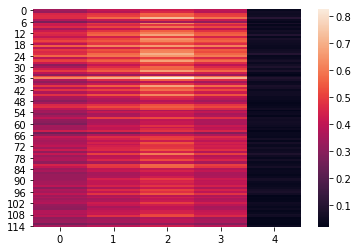

In [217]:
X = get_X_features(fragility_dataset, feature_name='data')

print(X.shape)

sns.heatmap(X)

In [334]:
dataset = beta_dataset

X = get_X_features(dataset, feature_name='data')
# get the y-labels 
subjects = np.array(dataset['subject'])
roots = dataset['roots']

exp_conditions = []
for subject, root in zip(subjects, roots):
    subj_df = _get_exp_condition(subject, root)
    exp_condition = subj_df["exp_condition"].values[0]
    exp_conditions.append(exp_condition)
print(np.unique(exp_conditions))

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [335]:
y = y_enc.fit_transform(exp_conditions)
y_classes = y_enc.classes_
print(y_enc.classes_)

['epilepsy-abnormal-eeg' 'epilepsy-normal-eeg' 'non-epilepsy-normal-eeg']


In [336]:
y = convert_experimental_cond_to_y(exp_conditions)
y = np.array(y)

In [33]:
from numpy.testing import assert_array_equal

for ch_names_ in dataset['ch_names']:
    assert_array_equal(ch_names, ch_names_)

print(ch_names)

NameError: name 'ch_names' is not defined

# Define Cross Validation Experiment

In [337]:
n_splits = 20
train_size = 0.7
random_state = 12345

In [338]:
cv = StratifiedGroupKFold(
    n_splits=n_splits,
    random_state=random_state,
    shuffle=True,
)
cv = StratifiedShuffleSplit(
    n_splits=n_splits,
    train_size=train_size,
    random_state=random_state,
)

## Define Classification Models

In [339]:
random_state = 12345
#clf_name = "sporf"
clf_name = 'lr'
max_features = X.shape[1]

rf_model_params = {
    "n_estimators": 1000,
    "max_features": max_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {"n_jobs": -1, "random_state": random_state}

In [340]:
if clf_name == "rf":
    clf = RandomForestClassifier(**rf_model_params)
elif clf_name == "sporf":
    # only used if you installed cysporf
    clf = ObliqueForestClassifier(**rf_model_params)
elif clf_name == "lr":
    clf = LogisticRegression(**lr_model_params)

# Run sklearn.cross_validate

In [341]:
clf = make_pipeline(StandardScaler(), clf)
print(X.shape, y.shape)
print(clf)

(115, 5) (115,)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=12345))])


In [342]:
scoring_funcs = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'cohen_kappa_score': make_scorer(cohen_kappa_score),
    'roc_auc': 'roc_auc', #roc_auc_score,
    'f1': 'f1', #f1_score,
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'jaccard': make_scorer(jaccard_score),
    'average_precision': make_scorer(average_precision_score),
    'neg_brier_score': make_scorer(brier_score_loss),
}

# define multiclass cross_validation scoring metrics
f1_micro = lambda x : make_scorer(f1_score, average='micro')
recall_micro = lambda x : make_scorer(recall_score, average='micro')
precision_micro = lambda x: make_scorer(precision_score, average='micro')
jaccard_micro = lambda x: make_scorer(jaccard_score, average='micro')
roc_ovr = lambda x: make_scorer(roc_auc_score, multi_class='ovr')
multiclass_scoring_funcs = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'cohen_kappa_score': make_scorer(cohen_kappa_score),
    'roc_auc_ovr': 'roc_auc_ovr',# roc_ovr,
    'f1_micro': 'f1_micro', #f1_micro,
    'recall_micro': 'recall_micro',
    'precision_micro': 'precision_micro',
    'jaccard_micro': 'jaccard_micro',
}

if len(np.unique(y)) == 2:
    scoring = scoring_funcs
else:
    scoring = multiclass_scoring_funcs
    
print(scoring)

{'balanced_accuracy': make_scorer(balanced_accuracy_score), 'cohen_kappa_score': make_scorer(cohen_kappa_score), 'roc_auc': 'roc_auc', 'f1': 'f1', 'recall': make_scorer(recall_score), 'precision': make_scorer(precision_score), 'jaccard': make_scorer(jaccard_score), 'average_precision': make_scorer(average_precision_score), 'neg_brier_score': make_scorer(brier_score_loss)}


In [343]:
# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    groups=subjects,
    cv=cv,
    scoring=scoring,
    return_estimator=True,
    return_train_score=True,
    n_jobs=-1,
)

# get the estimators
estimators = scores.pop("estimator")

In [344]:
print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_fraction_pos",
    "train_mean_pred_value",
    "train_y_pred_proba",
    "train_fpr",
    "train_tpr",
    "train_fnr",
    "train_tnr",
    "train_thresholds",
    "train_subjects",
    "test_subjects",
    "test_y_pred_proba",
    "test_importances",
    "test_specificity",
    "test_y",
    "test_y_encodings",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]

    # append subjects
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_y"].append(y[test_inds])
#     scores["test_y_encodings"].append(y_encode[test_inds])

    # evaluate on the test set
    y_train = y[train_inds]
    X_train = X[train_inds, :]
    y_pred_prob = estimator.predict_proba(X_train)[:, 1]
    print(y_pred_prob.shape)

    # compute calibration curve
    if len(np.unique(y)) == 2:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_train, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["train_fraction_pos"].append(fraction_of_positives)
        scores["train_mean_pred_value"].append(mean_predicted_value)

    # append training data
    scores["train_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y)) == 2:
        fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_train, y_pred_prob, pos_label=0)
        scores["train_fpr"].append(fpr)
        scores["train_tpr"].append(tpr)
        scores["train_fnr"].append(fnr)
        scores["train_tnr"].append(tnr)
        scores["train_thresholds"].append(thresholds)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)
    y_pred_label = np.argmax(y_pred_prob, axis=1)
    y_pred_prob = y_pred_prob[:, 1]

    # compute calibration curve
    if len(np.unique(y)) == 2:
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_prob, n_bins=10, strategy="quantile"
        )
        scores["test_fraction_pos"].append(fraction_of_positives)
        scores["test_mean_pred_value"].append(mean_predicted_value)
    
    # append testing data
    scores["test_y_pred_proba"].append(y_pred_prob)

    # store ROC curve metrics on the held-out test set
    if len(np.unique(y)) == 2:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
        fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
        scores["test_fpr"].append(fpr)
        scores["test_tpr"].append(tpr)
        scores["test_fnr"].append(fnr)
        scores["test_tnr"].append(tnr)
        scores["test_thresholds"].append(thresholds)

    conf_matrix = confusion_matrix(
        y_test.astype(int), (y_pred_label).astype(int)
    )
    if len(np.unique(y)) == 2:
        tn, fp, fn, tp = conf_matrix.ravel()
        scores["test_specificity"].append(tn / (tn + fp))

    # get the permutation importances
    r = permutation_importance(
        estimator, X_test, y_test, n_repeats=5, random_state=random_state, n_jobs=-1,
        scoring='roc_auc_ovr'
    )
    scores["test_importances"].append(r.importances)

Using estimator  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=12345))])
(80,)
[0.29900618 0.44998563 0.56511292 0.63983984 0.69564021 0.73281072
 0.76897528 0.79345658 0.82965377 0.86012288 0.96579128]
[0.33417496 0.46450749 0.58066286 0.61865546 0.66930611 0.69068296
 0.72531211 0.74458523 0.81997421 0.84834468 0.90525352]
(80,)
[0.34162992 0.51632802 0.59771861 0.66343058 0.69282471 0.72757584
 0.75182477 0.78066973 0.79832924 0.82953765 0.88057182]
[0.37500034 0.49571874 0.56776769 0.59165114 0.65602175 0.68758501
 0.73777015 0.763062   0.7953365  0.83346799 0.94714282]
(80,)
[0.29005621 0.4929672  0.57097946 0.65418521 0.68369097 0.72773075
 0.75812894 0.79452792 0.83733571 0.86291444 0.96771479]
[0.36281719 0.42537905 0.5435418  0.60089042 0.63060617 0.70984079
 0.73089674 0.78788762 0.82877735 0.83119104 0.91148493]
(80,)
[0.3479171  0.48972522 0.60965251 0.64810615 0.68523

In [345]:
# add metadata
scores['y_classes'] = y_classes
scores['abnormal_fpaths'] = abnorm_bidspaths

## Save Model Output Scores

In [346]:
exp_name = 'betaquantiles_jhhjeff_spikes'
fname = (
    deriv_root.parent
    / "derivatives"
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_{exp_name}.json"
)
print(fname)

D:\OneDriveParent\OneDrive - Johns Hopkins\Shared Documents\bids\derivatives\cv20_lr_mtry5_betaquantiles_jhhjeff_spikes.json


In [347]:
with open(fname.with_suffix(".json"), "w") as fp:
    json.dump(scores, fp, cls=NumpyEncoder)